## 作業

1. 如何使用已經訓練好的模型？
2. 依照 https://github.com/qqwweee/keras-yolo3 的程式碼，請敘述，訓練模型時，資料集的格式是什麼？具體一點的說，要提供什麼格式的文件來描述資料集的圖片以及 bboxes 的信息呢？





In [1]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
# pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [3]:
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

/media/rogerchang/Data/python/cvdl/term_project/keras-yolo3


In [4]:
import os
from xml.etree import ElementTree
import numpy as np

In [5]:
if not os.path.exists('model_data/yolov3.h5'):
    # os.system('wget https://pjreddie.com/media/files/yolov3.weights')
    os.system('python convert.py yolov3.cfg yolov3.weights model_data/yolov3.h5')
else:
    pass

In [6]:
if not os.path.exists('animals_train.txt'):
    sets = ['train', 'val']
    
    classes = ["kangaroo", "raccoon"]
    
    def dump_info(xml_path, list_file):
        f = open(xml_path)
        tree = ElementTree.parse(f)
        root = tree.getroot()
        
        for obj in tree.iter('object'):
            diff = int(obj.find('difficult').text)
            cls_name = obj.find('name').text
            
            if cls_name not in classes or diff == 1:
                continue
                
            cls_index = classes.index(cls_name)
            bndbox = obj.find('bndbox')
            
            b = (int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmax').text), int(bndbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_index))
            
        f.close()
        
    
    images_dir = ['animals/kangaroo/images', 'animals/raccoon/images']
    for s in sets:
        list_file = open('animals_%s.txt' % s, 'w')
        
        for i, annotation_path in enumerate(['animals/kangaroo/annots', 'animals/raccoon/annotations']):
            annots = os.listdir(annotation_path)
            annots.sort()
            annot_size = len(annots)
            split_num = int(np.round(annot_size * 0.8))
        
            if s == 'train':
                data = annots[:split_num]
            else:
                data = annots[split_num:]
                
            for d in data:
                name = d.split('.')[0]
                list_file.write(os.path.join(images_dir[i], '%s.jpg' % name))
                dump_info(os.path.join(annotation_path, d), list_file)
                list_file.write('\n')
        
        list_file.close()
        

In [7]:
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

import time

Using TensorFlow backend.


In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.set_session(sess)

In [10]:
from train import get_classes, get_anchors, create_model, create_tiny_model

In [11]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes, is_train=True):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0 and is_train:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=is_train, jitter=.7, hue=.3, sat=1.5, val=2.0)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [12]:
annotation_path = 'animals_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/%s/' % str(int(time.time()))# 訓練好的模型儲存的路徑
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo.h5')
else:
    model = create_model(input_shape, anchors, num_classes, 
        freeze_body=2, weights_path='model_data/Day41_trained_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    train_lines = f.readlines()
with open('animals_val.txt') as f:
    val_lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(train_lines)
np.random.seed(None)
num_val = len(val_lines)
num_train = len(train_lines)

Create YOLOv3 model with 9 anchors and 2 classes.


/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (75, 1024, 1, 1)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (75,)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (75, 512, 1, 1)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (75,)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/te

Load weights model_data/Day41_trained_weights.h5.
Freeze the first 249 layers of total 252 layers.


In [13]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Train on 291 samples, val on 73 samples, with batch size 4.
Epoch 1/100
72/72 [==============================] - 14s 188ms/step - loss: 1026.1820 - val_loss: 117.6251
Epoch 2/100
72/72 [==============================] - 11s 148ms/step - loss: 97.5725 - val_loss: 64.5697
Epoch 3/100
72/72 [==============================] - 11s 154ms/step - loss: 62.0928 - val_loss: 45.7293
Epoch 4/100
72/72 [==============================] - 11s 147ms/step - loss: 47.1926 - val_loss: 36.4777
Epoch 5/100
72/72 [==============================] - 11s 151ms/step - loss: 38.2564 - val_loss: 30.7721
Epoch 6/100
72/72 [==============================] - 11s 149ms/step - loss: 33.6336 - val_loss: 27.6896
Epoch 7/100
72/72 [==============================] - 11s 150ms/step - loss: 30.1413 - val_loss: 25.4786
Epoch 8/100
72/72 [==============================] - 11s 151ms/step - loss: 27.6655 - val_loss: 23.6400
Epoch 9/100
72/72 [==============================] - 12s 161ms/step - loss: 25.9781 - val_loss: 22.4219
E

In [14]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator(train_lines, batch_size, input_shape, anchors, num_classes, True),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator(val_lines, batch_size, input_shape, anchors, num_classes, False),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 291 samples, val on 73 samples, with batch size 4.
Epoch 101/200
72/72 [==============================] - 24s 337ms/step - loss: 17.0257 - val_loss: 15.2727
Epoch 102/200
72/72 [==============================] - 18s 256ms/step - loss: 15.9269 - val_loss: 14.9916
Epoch 103/200
72/72 [==============================] - 18s 256ms/step - loss: 15.6721 - val_loss: 14.6198
Epoch 104/200
72/72 [==============================] - 18s 256ms/step - loss: 15.2326 - val_loss: 14.5908
Epoch 105/200
72/72 [==============================] - 18s 256ms/step - loss: 15.2045 - val_loss: 14.6593
Epoch 106/200
72/72 [==============================] - 18s 256ms/step - loss: 15.1931 - val_loss: 14.5758
Epoch 107/200
72/72 [==============================] - 18s 256ms/step - loss: 15.2797 - val_loss: 14.4810
Epoch 108/200
72/72 [==============================] - 18s 256ms/step - loss: 15.3183 - val_loss: 15.0393
Epoch 109/200
72/72 [==============================] - 18s 256ms

In [15]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

logs/1583814591/trained_weights_final.h5 model, anchors, and classes loaded.


In [16]:
from PIL import Image
from IPython import display

In [ ]:
for file in os.listdir('../test_img/'):
    img = Image.open(os.path.join('../test_img/', file))
    r_img = yolo_model.detect_image(img)
    display.display(r_img)

In [18]:
print(log_dir)

logs/1583814591/


In [19]:
import matplotlib.pyplot as plt

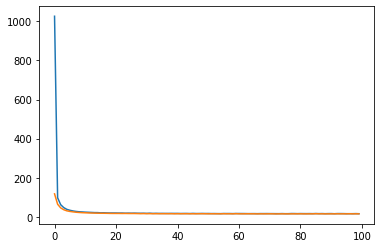

In [20]:
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])

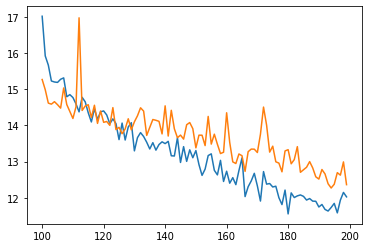

In [21]:
plt.plot(history2.epoch, history2.history['loss'], history2.epoch, history2.history['val_loss'])